In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys 

sys.path.append('../')
import methods.ddm as ddm 
import methods.likelihood as lh

from tqdm.notebook import tqdm


In [2]:
# Plotting settings 
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = [13,8]

# DDM Proof of Concept on synthetic data 

### Create imagery 

First, we create `n_locs` locations, each of which has `T` images over time. Each location has one permanent building, and one building which is being constructed over the course of the timeseries. We add random noise from a beta distribution to each image.  

In [4]:
n_locs = 10 
T = 10

locs = np.empty((n_locs, 10, 200, 200))

def random_building(a, loc='left'):
    
    rand = np.random.randint
    
    if loc == 'left':
        l = rand(round(a.shape[2]/2))
    else: 
        l = rand(round(a.shape[2]/2),a.shape[2]-50)
    r = l + rand(10, 50)
    b = rand(a.shape[1]-50)
    t = b + rand(10, 50)
    
    return l, r, b, t
    
    

for i in range(n_locs):

    a = np.zeros((1, 200, 200))
    
    # Create one static building 
    l1, r1, b1, t1 = random_building(a, loc='left') 
    a[0, b1:t1, l1:r1] = 1
    
    # And second growing over time 
    l2, r2, b2, t2 = random_building(a)
    a = np.repeat(a, 10, axis=0)
    bldg = np.ones_like(a[:, b2:t2, l2:r2])
    weights = [
        np.random.beta(6*1/T*(i+1),1, size=(t2-b2,r2-l2)) # noise 
        for i in range(T)
    ]
    bldg = np.stack([
        w*bldg[i,:,:] for i,w in enumerate(weights)
    ])
    a[:, b2:t2, l2:r2] = bldg
    
    # Add to rest of image 
    a[a == 1] = np.random.beta(6, 1, size=np.sum(a == 1))
    a[a == 0] = np.random.beta(1, 5, size=np.sum(a == 0))
    
    locs[i,:,:,:] = a
    
locs.shape

(10, 10, 200, 200)

Visualize random location

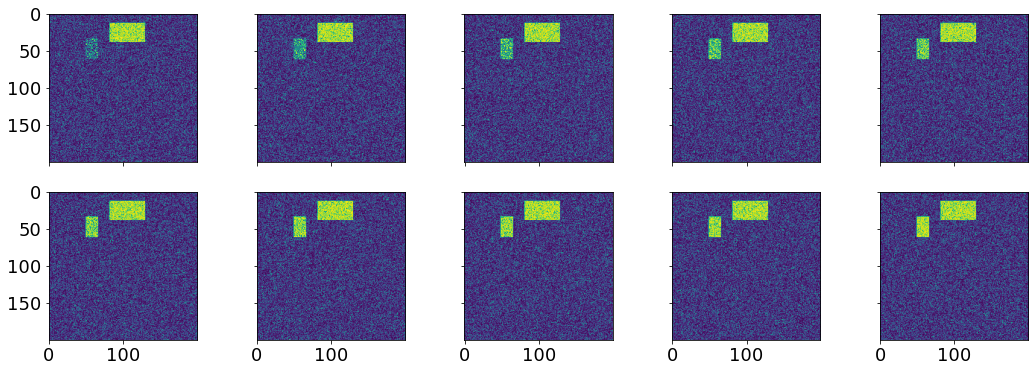

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(18,6), sharex=True, sharey=True)
ax = ax.ravel()

ind = np.random.randint(n_locs)
for i in range(n_locs):
    ax[i].imshow(locs[ind, i, :, :])

### Fit DDM Model. 

The model requires two inputs: The basis images (`X_train`) over which the weights are being computed and the true subsequent image that the model should predict (`y_train`). We take as `X_train` the first `T-1` images from each location, and the `T`-th image as the truth. 

`X_train` should have shape (No. locations, `T-1`, dim x, dim y, 1), and `y_train` should have shape (No. locations, 1, dim x, dim y, 1). 

In [7]:
X_train = locs[:,:9,:,:]
y_train = locs[:,-1,:,:]

X_train = tf.expand_dims(tf.convert_to_tensor(X_train, dtype=float), axis=-1)
y_train = tf.reshape(
    tf.convert_to_tensor(y_train, dtype=float), 
    (y_train.shape[0], 1, y_train.shape[1], y_train.shape[2], 1)
)

print(X_train.shape, y_train.shape)

(10, 9, 200, 200, 1) (10, 1, 200, 200, 1)


In [12]:
model = ddm.fit_observation(X_train, y_train, num_steps=2000, learning_rate=0.01,
                            reg=0.001, normalization='none')

iterating with 0.0 outliers present
12.0 outliers
max z 4.951727867126465


`model['gamma']` gives the weights generated by the model. There are `T` weights, the first is the constant offset, and 
rest are the coefficients for images 1,...,`T-1`. 

In [13]:
model['gamma'].numpy().ravel()

array([-0.03057145,  0.07923145,  0.08366905,  0.09311062,  0.12413231,
        0.1219151 ,  0.11205328,  0.12503625,  0.14526561,  0.13137981],
      dtype=float32)

We can also see the root mean squared error of the model: 

In [14]:
model['rmse']

0.15267296

### Prediction and Anomaly Detection

For testing, we'll simply use an arbitrary location. We add an additional building to y_train, not predictable based on previous images. This should be picked up as an anomaly by the model.  

In [15]:
i = np.random.randint(n_locs)
X_test = X_train[i]
y_test = y_train[i].numpy()

y_test[:,10:30,10:30, :] = 1 # add anomaly 
y_test = tf.convert_to_tensor(y_test)

Predict the image using the linear combination of previous images. 

In [16]:
y_pred = ddm.predict(model['gamma'], X_test)

Difference between predicted image and true image 

In [17]:
anomaly = ddm.hot_detect(model['gamma'], X_test, y_test, model['rmse'])

Text(0.5, 1.0, 'Anomaly')

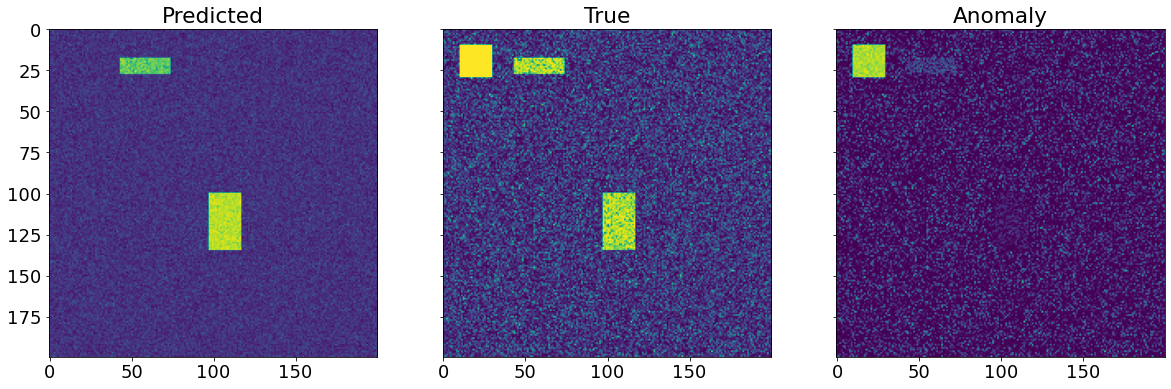

In [18]:
fig, ax = plt.subplots(1,3,figsize=(20,20), sharey=True)
ax = ax.ravel()

ax[0].imshow(y_pred[0,:,:,0].numpy()) 
ax[0].set_title('Predicted')

ax[1].imshow(y_test[0,:,:,0].numpy())
ax[1].set_title('True')

ax[2].imshow(anomaly[0,:,:,0].numpy())
ax[2].set_title('Anomaly')

We can also reduce the anomaly detection to a single score: 

In [19]:
ddm.hot_detect(model['gamma'], X_test, y_test, model['rmse'], reduce=True)

20815.441